In [40]:
# Подключение необходимых библиотек
import pandas as pd
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import category_encoders as ce # импорт для работы с кодировщиком
from sklearn.model_selection import train_test_split
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import tree #модели деревьев решения
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
import pickle

import warnings # для игнорирования предупреждений
#Игнорируем предупреждения
warnings.filterwarnings('ignore')
# Устанавливаем стиль визуализаций в matplotlib
%matplotlib inline
plt.style.use('seaborn')

In [41]:
data = pd.read_csv('my_df.csv')
display(data.head())

,ogrn,shortName,regionCode,regionName,dateReg,dateOgrn,dateLiquid,originDate,egrulStatus,incomeTotal,...,sumFedSubsidies,sumContracts,SM_youtube,SM_vk,SM_facebook,SM_twitter,SM_instagram,SM_ok,addOkved_name,addOkved_code
0,1207800141790,"""АМА""",78,Санкт-Петербург,NaN,2020-10-30,NaN,2020-10-30,Действует,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,undefined,undefined
1,1207700349152,"ФОНД ""УНИВЕРСАЛИСТ М""",77,Москва,NaN,2020-09-23,NaN,2020-09-23,Действует,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Издание книг;Издание газет;Виды издательской д...,58.11;58.13;58.19;59.20.1
2,1207800011430,NaN,78,Санкт-Петербург,NaN,2020-02-03,NaN,2020-02-03,Действует,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,undefined,undefined
3,1207700348976,"ТСН ""ЛУГИНИНО ПАРК""",77,Москва,NaN,2020-09-23,NaN,2020-09-23,Действует,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Аренда и управление собственным или арендованн...,68.20;68.10
4,1207800081500,"АНО ""ЦЕНТР ""ПЕТЕРБУРГФОРУМ""",78,Санкт-Петербург,NaN,2020-07-08,NaN,2020-07-08,Действует,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Исследование конъюнктуры рынка и изучение обще...,73.20;58.11.1;93.29.9;85.41.9;88.99;70.21


### 2. Анализ и обработка данных

In [42]:
# Для первичного анализа набора данных воспользуемся библиотекой sweetviz
report = sv.analyze(data)
report.show_html('my_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report my_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
ERROR: comet_ml is installed, but not configured properly (e.g. check API key setup). HTML reports will not be uploaded.


С помощью быстрого анализа данных библиотекой sweetviz, видим, что ряд признаков отвечающих за наличие записей организации в соцсетях, содержат более 99% пропусков. Необходимо удалить эти признаки. Вычислить зависимость вероятности получения организацией грантов от государства/госконтрактов от её публичности (записей в соцсетях), не представляется возможным.

In [43]:
display(data[['SM_youtube','SM_vk','SM_ok','SM_facebook','SM_twitter', 'SM_instagram']].info())
data = data.drop(['SM_youtube','SM_vk','SM_ok','SM_facebook','SM_twitter', 'SM_instagram'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SM_youtube    2 non-null      object
 1   SM_vk         5 non-null      object
 2   SM_ok         2 non-null      object
 3   SM_facebook   5 non-null      object
 4   SM_twitter    2 non-null      object
 5   SM_instagram  1 non-null      object
dtypes: object(6)
memory usage: 34.2+ MB


None

In [44]:
print('Размерность датасета: ', data.shape)
print('Количество уникальных НКО в датасете: ', data['ogrn'].count()) #unicue

Размерность датасета:  (747034, 23)
Количество уникальных НКО в датасете:  747034


Видим, что каждая строка в датасете представляет из себя запись о конкретной НКО, которые не повторяются (являются уникальными).

Рассмотрим характеристики признаков:

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ogrn                747034 non-null  int64  
 1   shortName           597793 non-null  object 
 2   regionCode          747034 non-null  int64  
 3   regionName          747009 non-null  object 
 4   dateReg             321416 non-null  object 
 5   dateOgrn            747034 non-null  object 
 6   dateLiquid          399961 non-null  object 
 7   originDate          747034 non-null  object 
 8   egrulStatus         747034 non-null  object 
 9   incomeTotal         747034 non-null  float64
 10  hasRegionalSupport  747034 non-null  bool   
 11  minjustForm         461073 non-null  object 
 12  minjustStatus       462302 non-null  object 
 13  opf_name            746619 non-null  object 
 14  opf_code            701825 non-null  float64
 15  opf_version         746619 non-nul

Пропущенные значения в признаке 'regionName' заполним значением 'unknown', заполнить их корректными названиями регионов не представляется возможным, т.к. соответствующие значения в столбце 'regionCode' = 0 (не существует региона РФ с таким кодом).

In [46]:
data['regionName'] = data['regionName'].fillna('unknown')

Сформируем признак 'age' - возраст организации в годах. Мы знаем, что до 2002 года датой создания организации считалась дата регистрации (столбец 'dateReg'), а после - дата присвоения ОГРН (столбец 'dateOgrn'). Ктоме того, мы имеем дамп данных актуальный на 26.08.2021 год, поэтому пропущенным значениям в столбце 'dateLiquid' (дата ликвидации) присвоим 2021 год. Так же проведенные исследования показали, что есть 4 НКО, у которых дата создания('dateReg'/'dateOgrn') больше года ликвидации. При этом год образования ('originDate') совпадает с годом ликвидации. Просто присвоим значению возраста "age" у таких НКО ноль.

In [47]:
data['dateReg'] =pd.to_datetime(data['dateReg']).dt.year.fillna(0)
data['dateOgrn'] =pd.to_datetime(data['dateOgrn']).dt.year.fillna(0)
data['dateLiquid'] =pd.to_datetime(data['dateLiquid']).dt.year.fillna(2021)
data['originDate'] =pd.to_datetime(data['originDate']).dt.year.fillna(0)

data['age'] = data['dateLiquid'] 

mask = (0 < data['dateReg']) & (data['dateReg']<=2002) & (data['dateOgrn']==0)
data['age'][mask] -= data['dateReg'][mask]

mask2 = (data['dateReg']==0) & (0<data['dateOgrn'])
data['age'][mask2] -= data['dateOgrn'][mask2]

mask3 = (0<data['dateReg']) & (0<data['dateOgrn']) 
data['age'][mask3] -= data['dateReg'][mask3]

mask4 = data['age'] < 0
data[mask4] = 0

# Удаляем столбцы 'egrulStatus' и 'minjustStatus', так как они нам более не понадобятся 
# при этом, руководствуемся логикой, что НКО могла быть ликвидирована уже после получения гранта от государства
data = data.drop(['dateReg', 'dateOgrn', 'dateLiquid', 'originDate', 'egrulStatus', 'minjustStatus'], axis=1)
display(data.head())

,ogrn,shortName,regionCode,regionName,incomeTotal,hasRegionalSupport,minjustForm,opf_name,opf_code,opf_version,mainOkved_name,mainOkved_code,sumGrants,sumFedSubsidies,sumContracts,addOkved_name,addOkved_code,age
0,1207800141790,"""АМА""",78,Санкт-Петербург,0.0,False,"Объединения (союз, ассоциация) юридических лиц",Ассоциации (союзы),20600.0,okopf,Деятельность профессиональных членских организ...,94.12,0.0,0.0,0.0,undefined,undefined,1.0
1,1207700349152,"ФОНД ""УНИВЕРСАЛИСТ М""",77,Москва,0.0,False,Некоммерческий фонд,Фонды,70400.0,okopf,"Предоставление прочих финансовых услуг, кроме ...",64.99,0.0,0.0,0.0,Издание книг;Издание газет;Виды издательской д...,58.11;58.13;58.19;59.20.1,1.0
2,1207800011430,NaN,78,Санкт-Петербург,0.0,False,Коллегия адвокатов,Коллегии адвокатов,20616.0,okopf,Деятельность в области права,69.10,0.0,0.0,0.0,undefined,undefined,1.0
3,1207700348976,"ТСН ""ЛУГИНИНО ПАРК""",77,Москва,0.0,False,NaN,Товарищества собственников недвижимости,20700.0,okopf,Управление недвижимым имуществом за вознагражд...,68.32,0.0,0.0,0.0,Аренда и управление собственным или арендованн...,68.20;68.10,1.0
4,1207800081500,"АНО ""ЦЕНТР ""ПЕТЕРБУРГФОРУМ""",78,Санкт-Петербург,0.0,False,Автономная некоммерческая организация,Автономные некоммерческие организации,71400.0,okopf,Деятельность по организации конференций и выст...,82.30,0.0,0.0,0.0,Исследование конъюнктуры рынка и изучение обще...,73.20;58.11.1;93.29.9;85.41.9;88.99;70.21,1.0


Создадим новый признак 'total_sum' суммируя признаки 'sumGrants', 'sumFedSubsidies' и 'sumContracts' (где 'sumContracts'='contracts44'+'contracts223'+'contracts94') и сравним его с уже имеющимся признаком 'incomeTotal'

In [48]:
data['total_sum'] = data['sumGrants'] + data['sumFedSubsidies'] + data['sumContracts']
data[['total_sum','incomeTotal']].describe()

,total_sum,incomeTotal
count,7.470340e+05,7.470340e+05
mean,5.163821e+06,5.163821e+06
std,1.552095e+09,1.552095e+09
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.227756e+12,1.227756e+12


In [49]:
# столбцы 'total_sum' и 'incomeTotal'получились идентичны, удалим один из них
data = data.drop(['total_sum', 'sumGrants', 'sumFedSubsidies', 'sumContracts'], axis=1)

Пропуски в столбцах 'minjustForm' и 'mainOkved_name' заполним значением 'unknown' (неизвестно)

In [50]:
data['minjustForm'] = data['minjustForm'].fillna('unknown')
data['mainOkved_name'] = data['mainOkved_name'].fillna('unknown')

Попробуем заполнить пропуски в столбце 'opf_name' взяв соответствующие значения из таблицы Lab_foundations_codes.csv с более точными кодами правовой формы (ОКОПФ)

In [51]:
print('Количество пропусков в столбце opf_name до коррекции: ', data[['opf_name']].isnull().sum())
print('Количество пропусков в столбце opf_code до коррекции: ', data[['opf_code']].isnull().sum())
# Считываем таблицу с более точными кодами правовой формы
tab_okopf = pd.read_csv("raw.githubusercontent.com_Teplitsa_CSRLab_main_Skillfactory x Teplitsa Lab_foundations_codes.csv")
display(tab_okopf.head())

Количество пропусков в столбце opf_name до коррекции:  opf_name    415
dtype: int64
Количество пропусков в столбце opf_code до коррекции:  opf_code    45209
dtype: int64


,name,ogrn,status,region,okopf,okopf_id
0,"ФОНД ""+7""",1.157700e+12,Действующая,Москва,Фонды,70400
1,"100 ЛЕТ ПРОФДВИЖЕНИЯ РОССИИ, ФОНД",1.047797e+12,Действующая,Москва,Фонды,70400
2,"100+1, ФОНД",1.167700e+12,Действующая,Москва,Фонды,70400
3,"100-ЛЕТИЕ СССР, ФОНД",1.187700e+12,Действующая,Москва,Фонды,70400
4,"101 КИЛОМЕТР. ПОДВИЖНИКИ МАЛОЯРОСЛАВЦА, БФ",1.167700e+12,Действующая,Москва,Благотворительные фонды,70401


In [52]:
data = data.merge(tab_okopf[['ogrn', 'okopf', 'okopf_id']], left_on='ogrn', right_on='ogrn', how='left') 
display(data.head())

,ogrn,shortName,regionCode,regionName,incomeTotal,hasRegionalSupport,minjustForm,opf_name,opf_code,opf_version,mainOkved_name,mainOkved_code,addOkved_name,addOkved_code,age,okopf,okopf_id
0,1207800141790,"""АМА""",78,Санкт-Петербург,0.0,False,"Объединения (союз, ассоциация) юридических лиц",Ассоциации (союзы),20600.0,okopf,Деятельность профессиональных членских организ...,94.12,undefined,undefined,1.0,NaN,NaN
1,1207700349152,"ФОНД ""УНИВЕРСАЛИСТ М""",77,Москва,0.0,False,Некоммерческий фонд,Фонды,70400.0,okopf,"Предоставление прочих финансовых услуг, кроме ...",64.99,Издание книг;Издание газет;Виды издательской д...,58.11;58.13;58.19;59.20.1,1.0,Фонды,70400.0
2,1207800011430,NaN,78,Санкт-Петербург,0.0,False,Коллегия адвокатов,Коллегии адвокатов,20616.0,okopf,Деятельность в области права,69.10,undefined,undefined,1.0,NaN,NaN
3,1207700348976,"ТСН ""ЛУГИНИНО ПАРК""",77,Москва,0.0,False,unknown,Товарищества собственников недвижимости,20700.0,okopf,Управление недвижимым имуществом за вознагражд...,68.32,Аренда и управление собственным или арендованн...,68.20;68.10,1.0,NaN,NaN
4,1207800081500,"АНО ""ЦЕНТР ""ПЕТЕРБУРГФОРУМ""",78,Санкт-Петербург,0.0,False,Автономная некоммерческая организация,Автономные некоммерческие организации,71400.0,okopf,Деятельность по организации конференций и выст...,82.30,Исследование конъюнктуры рынка и изучение обще...,73.20;58.11.1;93.29.9;85.41.9;88.99;70.21,1.0,NaN,NaN


In [53]:
mask1 = data['opf_name'].isnull() 
data['opf_name'][mask1] = data['okopf'][mask1]
mask2 = data['opf_code'].isnull() 
data['opf_code'][mask2] = data['okopf_id'][mask2]

print('Количество пропусков в столбце opf_name после коррекции: ', data[['opf_name']].isnull().sum())
print('Количество пропусков в столбце opf_code после коррекции: ', data[['opf_code']].isnull().sum())

Количество пропусков в столбце opf_name после коррекции:  opf_name    415
dtype: int64
Количество пропусков в столбце opf_code после коррекции:  opf_code    45208
dtype: int64


Не получилось заполнить пропуски в столбцах 'opf_name' и 'opf_code' взятием информации из таблицы 'Lab_foundations_codes.csv', поэтому заполним их значениями 'unknown' и 0 соответственно.

In [54]:
data = data.drop(['okopf', 'okopf_id'], axis=1)
data['opf_name'] = data['opf_name'].fillna('unknown')
data['opf_code'] = data['opf_code'].fillna(0)

Создадим целевой признак 'incomeTotal_target', котоый будет принимать два значения 0 и 1. 1 - НКО получала деньги от государства, 0 - нет. Так же будем учитывать данные из столбца 'hasRegionalSupport' - организация была получателем региональной поддержки в качестве СО НКО.

In [55]:
mask = data['incomeTotal']>1
data['incomeTotal_target'] = (mask | data['hasRegionalSupport']).astype(int)

### 3. Визуализация данных

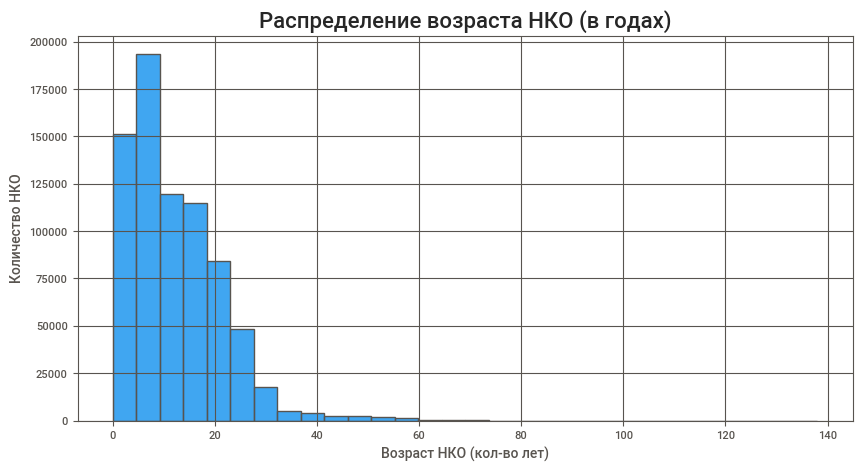

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
plt.subplots_adjust(hspace=.0)
histplot1 = sns.histplot(
    data=data, 
    x='age', 
    bins=30    
)
histplot1.set_title('Распределение возраста НКО (в годах)', fontsize=16)
histplot1.set_xlabel('Возраст НКО (кол-во лет)')
histplot1.set_ylabel('Количество НКО')
histplot1.grid()

Из гистограммы видим, что возраст большинства НКО варьирует в диапазоне 5-10 лет.

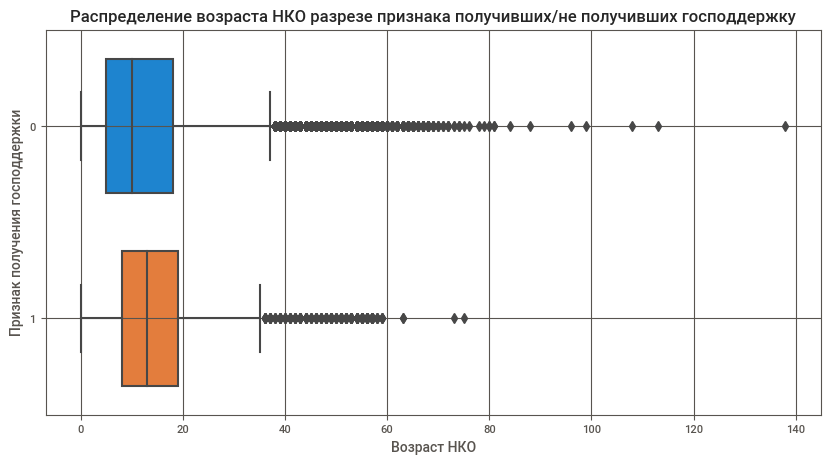

In [57]:
fig = plt.figure(figsize=(10, 5))
boxplot = sns.boxplot(
    data=data,
    y='incomeTotal_target',
    x='age',
    orient='h',
    width=0.7
)
boxplot.set_title('Распределение возраста НКО разрезе признака получивших/не получивших господдержку');
boxplot.set_xlabel('Возраст НКО');
boxplot.set_ylabel('Признак получения господдержки');
boxplot.grid()

Из графика коробчатой диаграммы видим, что возраст НКО, получивших гос.поддержку смещен к 15 годам.

In [58]:
data_tmp = data['regionName'].value_counts(normalize=True).sort_values(ascending=False).head(20).reset_index(name='frac')
#display(data_tmp)
#строим график
fig = px.treemap(
    data_frame=data_tmp, 
    path=['index'], #категориальный признак, для которого строится график 
    values='frac', #параметр, который сравнивается
    height=500, #высота
    width=1000, #ширина
    title='Соотношение регионов, где зарегистрированы НКО' #заголовок
)
#отображаем график
fig.show()

Иерархическая диаграмма демонстрирует нам, что большинство НКО зарегистрированы в Москве. Можно предположить, что наибольшее число НКО получивших деньги от государства, так же зарегистрированы в Москве.

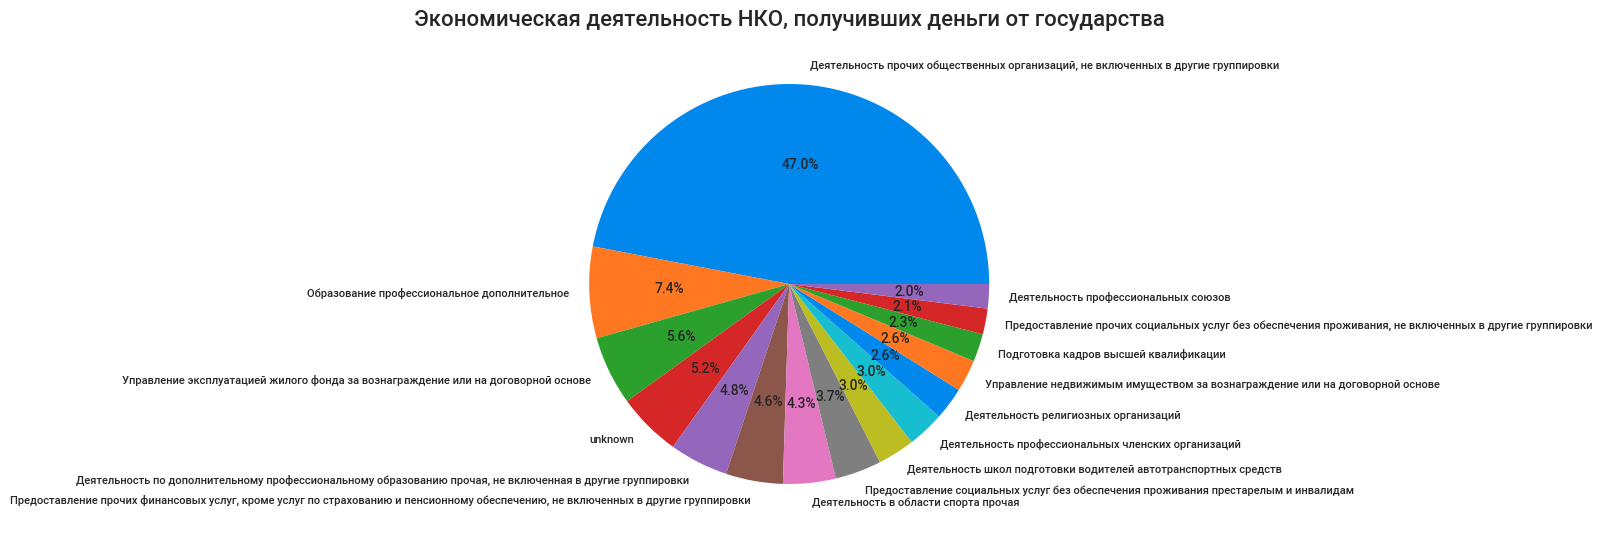

In [59]:
mask_1=data['incomeTotal_target']>0
mask_0=data['incomeTotal_target']==0

tab = data[mask_1]['mainOkved_name'].value_counts().sort_values(ascending=False).head(15)
#display(tab)
fig = plt.figure(figsize=(5,5))
axes = fig.add_axes([0,0,1,1])
axes.pie(
    tab,    
    labels=tab.index,
    autopct='%.1f%%'      
);
axes.set_title('Экономическая деятельность НКО, получивших деньги от государства', fontsize=16);

Из графика видно, что экономическая деятельность наибольшего количество НКО получающих гос.поддержку определяется как 'деятельность прочих общественных организаций'. 

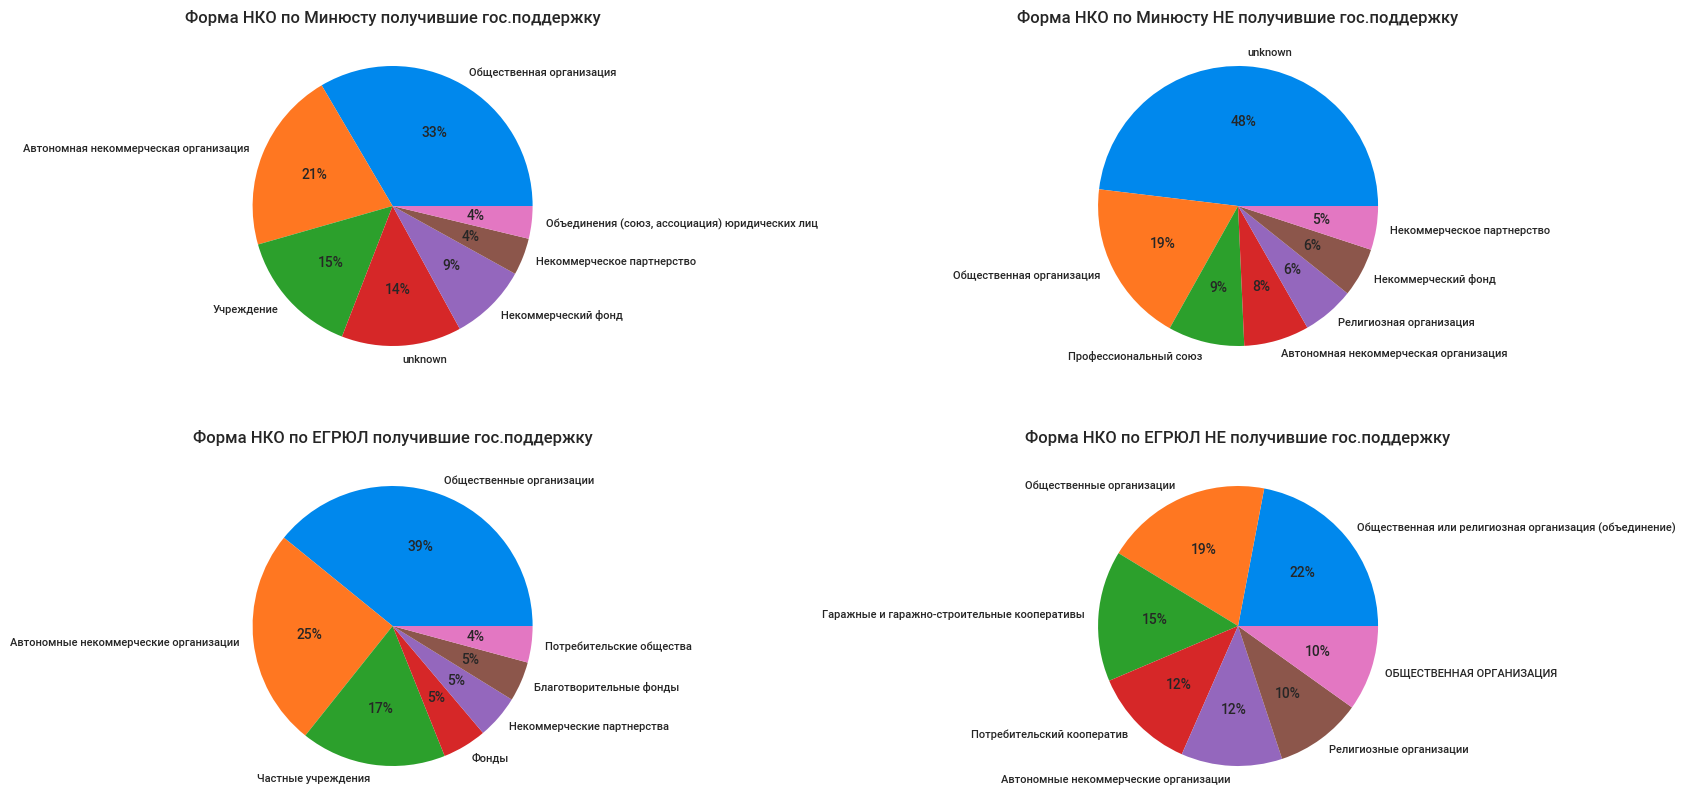

In [60]:
mf_1 = data[mask_1]['minjustForm'].value_counts().sort_values(ascending=False).head(7)
mf_0 = data[mask_0]['minjustForm'].value_counts().sort_values(ascending=False).head(7)

opf_1 = data[mask_1]['opf_name'].value_counts().sort_values(ascending=False).head(7)
opf_0 = data[mask_0]['opf_name'].value_counts().sort_values(ascending=False).head(7)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axes[0,0].pie(
    mf_1,
    labels=mf_1.index,
    autopct='%.0f%%'
    #explode = [0.05, 0]
);
axes[0,0].set_title('Форма НКО по Минюсту получившие гос.поддержку', fontsize=12); # форма НКО, согласно системе Минюста РФ

axes[0,1].pie(
    mf_0,
    labels=mf_0.index,
    autopct='%.0f%%'
    #explode = [0.05, 0]
);
axes[0,1].set_title('Форма НКО по Минюсту НЕ получившие гос.поддержку', fontsize=12);

axes[1,0].pie(
    opf_1,
    labels=opf_1.index,
    autopct='%.0f%%'
    #explode = [0.05, 0]
);
axes[1,0].set_title('Форма НКО по ЕГРЮЛ получившие гос.поддержку', fontsize=12); # сведения об организационно-правовой форме (ОПФ) организации на основании данных ЕГРЮЛ

axes[1,1].pie(
    opf_0,
    labels=opf_0.index,
    autopct='%.0f%%'
    #explode = [0.05, 0]
);
axes[1,1].set_title('Форма НКО по ЕГРЮЛ НЕ получившие гос.поддержку', fontsize=12);

Круговая диаграмма носит информационно-ознакомительный характер. Можем сравнить как отличаются формы НКО получившие гос. финансирование, зарегистрированные согласно системе Минюста и на основании данных ЕГРЮЛ. Видим, что форма НКО по системе Минюста и на основании ЕГРЮЛ очень похожи, а их различие можно списать на несогласованность баз данных разных ведомств. Поэтому в дальнейшем предлагается отказаться от анализа данных столбца 'minjustForm' и удалить его из датасета.

In [61]:
mask = data['incomeTotal'] > 0
data_tmp = data[mask]
bar_data = data_tmp.groupby(
    by='regionName',
    as_index=False
)[['incomeTotal']].mean().nlargest(10, columns=['incomeTotal'])
#display(bar_data)
#строим график
fig1 = px.bar(
    data_frame=bar_data, #датафрейм
    x="regionName", #ось x
    y="incomeTotal", #ось y
    color='regionName', #расцветка 
    #text = 'incomeTotal', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Зависимость средней величины гос.поддержки от региона' #заголовок    
)
#отображаем его
fig1.show()

График столбчатой диаграммы показывает, что в среднем величина гос. поддержки выше для НКО зарегистрированных в Москве.

In [62]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747034 entries, 0 to 747033
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ogrn                747034 non-null  int64  
 1   shortName           597793 non-null  object 
 2   regionCode          747034 non-null  int64  
 3   regionName          747034 non-null  object 
 4   incomeTotal         747034 non-null  float64
 5   hasRegionalSupport  747034 non-null  object 
 6   minjustForm         747034 non-null  object 
 7   opf_name            747034 non-null  object 
 8   opf_code            747034 non-null  float64
 9   opf_version         746619 non-null  object 
 10  mainOkved_name      747034 non-null  object 
 11  mainOkved_code      542357 non-null  object 
 12  addOkved_name       747034 non-null  object 
 13  addOkved_code       747034 non-null  object 
 14  age                 747034 non-null  float64
 15  incomeTotal_target  747034 non-nul

None

In [63]:
# Перед кодированием признаков удалим столбцы, которые нам больше не нужны
data = data.drop(['ogrn', 'shortName', 'regionCode', 'mainOkved_code', 'addOkved_code', 
                  'hasRegionalSupport', 'opf_code', 'opf_version', 
                  'minjustForm', 'incomeTotal'], axis=1)

data.to_csv('df_for_encoder.csv', index=False)
display(data.head())

,regionName,opf_name,mainOkved_name,addOkved_name,age,incomeTotal_target
0,Санкт-Петербург,Ассоциации (союзы),Деятельность профессиональных членских организ...,undefined,1.0,0
1,Москва,Фонды,"Предоставление прочих финансовых услуг, кроме ...",Издание книг;Издание газет;Виды издательской д...,1.0,0
2,Санкт-Петербург,Коллегии адвокатов,Деятельность в области права,undefined,1.0,0
3,Москва,Товарищества собственников недвижимости,Управление недвижимым имуществом за вознагражд...,Аренда и управление собственным или арендованн...,1.0,0
4,Санкт-Петербург,Автономные некоммерческие организации,Деятельность по организации конференций и выст...,Исследование конъюнктуры рынка и изучение обще...,1.0,0


### 4. Кодирование признаков

Воспользуемся двоичным кодировщиком BinaryEncoder для кодирования номинальных признаков (кол-во значений > 15), таких как регион, ОКВЭД, ОПФ.
Признак 'age' является порядковым, его не будем кодировать, т.к. он представляет возраст организации в годах, что по сути уже является закодированным значением.

In [64]:
bin_encoder = ce.BinaryEncoder(cols=['regionName', 'mainOkved_name', 'addOkved_name', 'opf_name']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data[['regionName', 'mainOkved_name','addOkved_name', 'opf_name']])
data = pd.concat([data, type_bin], axis=1)
data = data.drop(['regionName', 'mainOkved_name', 'addOkved_name', 'opf_name'], axis=1)

In [65]:
display(data.info())
print('Кол-во пропусков: ', data.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747034 entries, 0 to 747033
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   age                 747034 non-null  float64
 1   incomeTotal_target  747034 non-null  int32  
 2   regionName_0        747034 non-null  int64  
 3   regionName_1        747034 non-null  int64  
 4   regionName_2        747034 non-null  int64  
 5   regionName_3        747034 non-null  int64  
 6   regionName_4        747034 non-null  int64  
 7   regionName_5        747034 non-null  int64  
 8   regionName_6        747034 non-null  int64  
 9   mainOkved_name_0    747034 non-null  int64  
 10  mainOkved_name_1    747034 non-null  int64  
 11  mainOkved_name_2    747034 non-null  int64  
 12  mainOkved_name_3    747034 non-null  int64  
 13  mainOkved_name_4    747034 non-null  int64  
 14  mainOkved_name_5    747034 non-null  int64  
 15  mainOkved_name_6    747034 non-nul

None

Кол-во пропусков:  0


### 5. Решение задачи классификации

5.1. Воспользуемся моделью логистической регрессии для бинарной классификации

0    0.945189
1    0.054811
Name: incomeTotal_target, dtype: float64

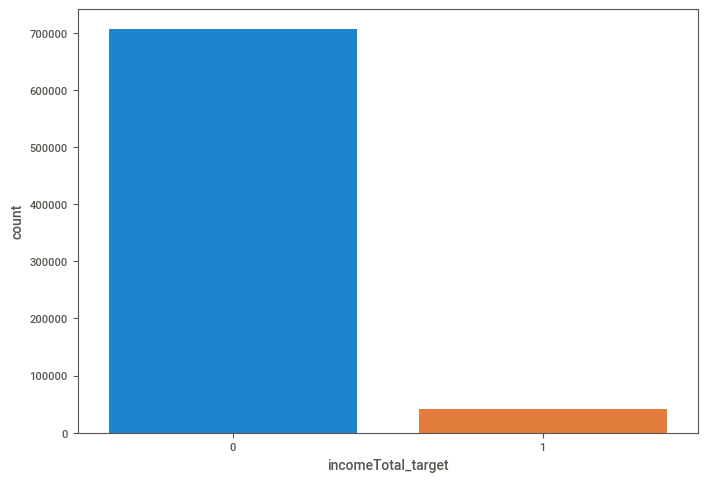

In [66]:
# Сначала выявим соотношение классов
display(data['incomeTotal_target'].value_counts(normalize=True))
sns.countplot(data=data, x='incomeTotal_target');

Видим, что классы (НКО получившие гос.поддержку/НКО не получившие гос.поддержку) не сбалансированы, учтём это обстоятельство при делении датасета на тренировочную и тестовую выборки.

In [67]:
X = data.drop(['incomeTotal_target'], axis=1)
y = data['incomeTotal_target']

# Разбиваем исходную выборку на тренировочную и тестовую в соотношении 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # попробуем сбалансировать соотношения

In [68]:
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(random_state=42)
#Обучаем модель
log_reg.fit(X_train, y_train)

y_predict = log_reg.predict(X_test) # predict_proba - предсказание вероятности
#Выводим значения метрик
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_predict)))
print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_predict)))
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_predict)))
print('F1 : {:.2f}'.format(metrics.f1_score(y_test, y_predict)))

Accuracy: 0.94
Precision: 0.37
Recall: 0.01
F1 : 0.01


Метрика accuracy = 0.94 показывает нам, как много (в долях) модель угадала ответов (достоверность).

Precission - способность отделить класс 1 от класса 0. Т.е., количество НКО получивших деньги от государства (по 'мнению' модели) и при этом действительно получивших, составило всего 37%. Т.е. имеем достаточно много ложноположительных срабатываний (точность).

Recall (полнота) - доля объектов, названных классификатором положительными, по отношению ко всем объектам положительного класса. Recall = 0.1, - велика вероятность допустить ложноотрицательное срабатывание (ошибку второго рода).

F1-мера - это взвешенное среднее гармоническое между precision и recall. Даёт обобщённое представление о точности и полноте. В нашем случае, F1 = 0.01, - низний показатель метрики связан с наличием большого числа ложных срабатываний (см. recall=0.01).

5.2. Дерево решений

In [69]:
#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=50, #максимальная глубина 
    #max_features # максимальное число признаков, по которым ищется лучшее разбиение в дереве
    #min_samples_leaf — минимальное число объектов в листе   
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений 
dt_clf.fit(X_train, y_train)

#Делаем предсказание
y_predict2 = dt_clf.predict(X_test)

#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_test, y_predict2))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    211827
           1       0.28      0.24      0.26     12284

    accuracy                           0.92    224111
   macro avg       0.62      0.60      0.61    224111
weighted avg       0.92      0.92      0.92    224111



5.3. Воспользуемся моделью случайного леса

In [70]:
#Создаём объект класса RandomForestClassifier
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=50, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=30, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подпространств
    #min_samples_leaf=1, #минимальное число объектов в листе (по умолчанию — 1);
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf.fit(X_train, y_train)
 
#Делаем предсказание
y_predict3 = rf_clf.predict(X_test)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_predict3))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    211827
           1       0.43      0.09      0.15     12284

    accuracy                           0.94    224111
   macro avg       0.69      0.54      0.56    224111
weighted avg       0.92      0.94      0.93    224111



5.4. Воспользуемся методом поиска по сетке (GridSearchCV), для подбора гиперпараметров для модели случайного леса.

In [71]:
# Сетка значений гиперпараметров
param_grid = {'n_estimators': list(range(40, 60, 10)), #число деревьев              
              'max_depth': list(range(20, 50, 10)) #максимальная глубина дерева              
              }             

grid_search = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(criterion='entropy', max_features='sqrt', random_state=42), 
    param_grid=param_grid, 
    cv=5, #количество фолдов в кросс-валидации, по умолчанию используется 5
    n_jobs = -1 # количество ядер для распараллеливания расчёта. -1 использует все существующие ядра
)
# %time - замеряет время выполнения
%time grid_search.fit(X_train, y_train) 
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Wall time: 20min 35s
Наилучшая модель:
RandomForestClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                       n_estimators=50, random_state=42)


In [72]:
rf_clf_2 = ensemble.RandomForestClassifier(
    criterion='entropy', 
    max_depth=20, 
    max_features='sqrt',
    n_estimators=50, 
    random_state=42
)
#Обучаем модель 
rf_clf_2.fit(X_train, y_train) 
#Делаем предсказание
y_predict4 = rf_clf.predict(X_test)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_predict4))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    211827
           1       0.43      0.09      0.15     12284

    accuracy                           0.94    224111
   macro avg       0.69      0.54      0.56    224111
weighted avg       0.92      0.94      0.93    224111



5.5. Создадим сводную таблицу

In [73]:
table = {'Model':['Логистическая регрессия', 'Дерево решений', 'Случайный лес', 'Случ. лес с подобранными гиперпарам.'], 
         'Accuracy':['0.94', '0.92', '0.94', '0.94'], 
         'Precission':['0.37', '0.28', '0.43', '0.43'], 
         'Recall':['0.01', '0.24', '0.09', '0.09'],
         'F1':['0.01', '0.26', '0.15', '0.15']
         }
table = pd.DataFrame(table)
display(table)

,Model,Accuracy,Precission,Recall,F1
0,Логистическая регрессия,0.94,0.37,0.01,0.01
1,Дерево решений,0.92,0.28,0.24,0.26
2,Случайный лес,0.94,0.43,0.09,0.15
3,Случ. лес с подобранными гиперпарам.,0.94,0.43,0.09,0.15


Для предсказания вероятности получения грантов/госконтрактов от государства выберем модель случайного леса (с подобранными гиперпараметрами), т.к. она обладает лучшими показателями метрик, из представленных моделей. 

### 6. Подготовка модели к продакшену

In [74]:
# Производим сериализацию обученной модели и записываем результат в файл формата pkl
with open('myfile.pkl', 'wb') as output:
    pickle.dump(rf_clf_2, output)